In [359]:
import numpy as np
import pandas as pd
import networkx as nx

# 1. Number of trees

Вычислим сперва количество ребер $edge(k)$ для неукорененного дерева с $k$ листьями.


Шаг индукции: при добавлении листа мы "подвешиваем" его к ребру одного из имеющихся листьев, деля это ребро на два и добавляя одно новое. Таким образом при добавлении листа количество ребер увеличивается на два. Если у нас $k$ листьев, то ребер будет $edge(k)=2k+b$. Вычислим $b$ из базы индукции. Для $k=2$ : $edge(2)=1=2*2-3$ отсюда $b=-3$ и $edge(k)=2k-3$.

Заметим, что количество неукорененных деревьев $n_{unrooted}(k+1)$ с $k+1$ листьями равно числу укоренённых $n_{rooted}(k)$ с $k$ листьями. Это так поскольку новый лист мы можем подвесить на ребре к корню каждого из укорененных деревьев. В свою очередь количество укорененных деревьев $n_{rooted}(k)$ с $k$ листьями равно количеству неукорененных $n_{unrooted}(k)$ умноженному на $edge(k)$, поскольку "подвесить" дерево мы можем за любое ребро.

Шаг индукции:
$$
k-1:~~~~~ n_{unrooted}(k-1)~~ = ~~m ~~~~~~~~~~~~~~~~~~~~~~~~~~ n_{rooted}(k-1) ~~= ~~m(2(k-1)-3)~~~~~ = ~~~m(2k-5)
$$ $$
k~~~~~~:~~~~~ n_{unrooted}(k) ~~~~~~~~~= ~~m(2k-5) ~~~~~~~~~~~~~ n_{rooted}(k) ~~~~~~~~= ~~m(2k-5)(2k-3)~~~~~~~~~~~~~~~~~~~~~~~~~
$$
База:
$$
k=3:~~~~~ n_{unrooted}(k)=1=(2k-5)!!~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
$$

Таким образом существует $(2k-5)!!$ неукорененных и $(2k-3)!!$ укорененных деревьев с $k$ листьями.

# 2. Weighted and Unweighted Pair Group Methods with Arithmetic Mean

In [352]:
def WPGMA(file_name):
    
    # Нахождение индексов минимального элемента матрицы
    def argmin(arr):
        s = np.shape(arr)
        am = arr.argmin()
        ind = []
        i = 0
        for d in s:
            i += 1
            if len(s[i:]):
                c = np.product(s[i:])
            else:
                c = 1
            ind.append(am // c)
            am %= c
        return tuple(ind)
    
    # Чтение таблицы из текстового файла
    with open(file_name, 'r') as matr:
        ind = next(matr).split() # массив имен листьев дерева
        M = np.zeros((len(ind), len(ind)))
        i = 0
        for line in matr:
            M[i,:] = np.array(list(map(int, line.split())))
            i += 1
        M -= np.tri(*M.shape)
        M = M.flatten()
        M[M < 0] = np.inf
        M = M.reshape((len(ind), len(ind)))
        M[-1,:] = 0 # используем эту строку для хранения уже учтенного в данном узле расстояния

    # Построение дерева
    while len(ind)-1:
        i, j = argmin(M[:-1,:])
        w = M[i,j]
        
        # вместо i-го элемента теперь элемент ij
        ind[i] = '(' + ind[i] + ':' + str(w/2 - M[-1,i]) + ', ' + ind[j] + ':' + str(w/2 - M[-1,j]) + ')'
        del ind[j]
        M[:-1,i] = (M[:-1,i] + M[:-1,j])/2
        M[-1,i] += w/2 - M[-1,i]
        
        # вырезаем строку j и столбец j
        if j == M.shape[0] - 1:
            M = np.hstack((M[:,:j],M[:,j+1:]))
        else:
            M = np.vstack((np.hstack((M[:j,:j],M[:j,j+1:])),np.hstack((M[j+1:,:j],M[j+1:,j+1:]))))
        
    return ind[0]

In [353]:
print(WPGMA('alignment_matrix_1.txt'))

(K:7.25, (L:4.0, (M:2.0, N:2.0):2.0):3.25)


In [354]:
print(WPGMA('alignment_matrix_2.txt'))

((((A:2.0, C:2.0):0.5, B:2.5):0.75, (D:2.5, E:2.5):0.75):0.75, F:4.0)


In [355]:
def UPGMA(file_name):
    
    # Определение размера кластера
    def gr_size(s):
        return s.count('(') + 1
    
    # Нахождение индексов минимального элемента матрицы
    def argmin(arr):
        s = np.shape(arr)
        am = arr.argmin()
        ind = []
        i = 0
        for d in s:
            i += 1
            if len(s[i:]):
                c = np.product(s[i:])
            else:
                c = 1
            ind.append(am // c)
            am %= c
        return tuple(ind)
    
    # Чтение таблицы из текстового файла
    with open(file_name, 'r') as matr:
        ind = next(matr).split() # массив имен листьев дерева
        M = np.zeros((len(ind), len(ind)))
        i = 0
        for line in matr:
            M[i,:] = np.array(list(map(int, line.split())))
            i += 1
        M -= np.tri(*M.shape)
        M = M.flatten()
        M[M < 0] = np.inf
        M = M.reshape((len(ind), len(ind)))
        M[-1,:] = 0 # используем эту строку для хранения уже учтенного в данном узле расстояния

    # Построение дерева
    while len(ind)-1:
        i, j = argmin(M[:-1,:])
        w = M[i,j]
        
        # вместо i-го элемента теперь элемент ij
        M[:-1,i] = (M[:-1,i]*gr_size(ind[i]) + M[:-1,j]*gr_size(ind[j]))/(gr_size(ind[i]) + gr_size(ind[j]))
        ind[i] = '(' + ind[i] + ':' + str(w/2 - M[-1,i]) + ', ' + ind[j] + ':' + str(w/2 - M[-1,j]) + ')'
        del ind[j]
        
        # вырезаем строку j и столбец j
        if j == M.shape[0] - 1:
            M = np.hstack((M[:,:j],M[:,j+1:]))
        else:
            M = np.vstack((np.hstack((M[:j,:j],M[:j,j+1:])),np.hstack((M[j+1:,:j],M[j+1:,j+1:]))))
        
    return ind[0]

In [356]:
print(UPGMA('alignment_matrix_1.txt'))

(K:7.0, (L:4.0, (M:2.0, N:2.0):4.0):7.0)


In [357]:
print(UPGMA('alignment_matrix_2.txt'))

((((A:2.0, C:2.0):2.5, B:2.5):3.25, (D:2.5, E:2.5):3.25):4.0, F:4.0)


# 3. Neighbor joining

In [358]:
def NJ(file_name):
    
    # Нахождение индексов минимального элемента матрицы
    def argmin(arr):
        s = np.shape(arr)
        am = arr.argmin()
        ind = []
        i = 0
        for d in s:
            i += 1
            if len(s[i:]):
                c = np.product(s[i:])
            else:
                c = 1
            ind.append(am // c)
            am %= c
        return tuple(ind)
    
    # Чтение таблицы из текстового файла
    with open(file_name, 'r') as matr:
        ind = next(matr).split() # массив имен листьев дерева
        M = np.zeros((len(ind), len(ind)))
        i = 0
        for line in matr:
            M[i,:] = np.array(list(map(int, line.split())))
            i += 1
        M += M.T
        
    # Вычисление Q-матрицы и нахождение индекса минимального элемента    
    def Q_min(M):
        n = M.shape[0]
        Q = np.zeros_like(M)
        for i in range(n):
            for j in range(n):
                Q[i,j] = (n-2)*M[i,j] - np.sum(M[i,:] + M[j,:])
        return argmin(Q + np.diag(np.ones(n)*np.inf))
    
    Tree = nx.Graph() # Неукорененное дерево которое мы будем строить
    
    while M.shape[0] > 2:
        i, j = Q_min(M)
        u = ind[i] + ind[j] # новая вершина - родитель i и j
        d_iu = M[i,j]/2 + np.sum(M[i,:] - M[j,:])/(2*(M.shape[0]-2)) # расстояние i-u
        d_ju = M[i,j] - d_iu # расстояние j-u

        # добавляем в дерево наши взвешенные ребра 
        Tree.add_edge(ind[i], u, weight=d_iu)
        Tree.add_edge(ind[j], u, weight=d_ju) 

        # обновляем список элементов
        ind[i] = u
        del ind[j]    

        # вместо i-го элемента теперь элемент u
        M_u = (M[i,:] + M[j,:] - M[i,j])/2
        M[i,:] = M_u
        M[:,i] = M_u

        # вырезаем строку j и столбец j
        M = np.vstack((np.hstack((M[:j,:j],M[:j,j+1:])),np.hstack((M[j+1:,:j],M[j+1:,j+1:]))))
    
    # объединяем две оставшиеся вершины
    Tree.add_edge(ind[0], ind[1], weight=M[0,1]) 
    
    return Tree

/home/hamit/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


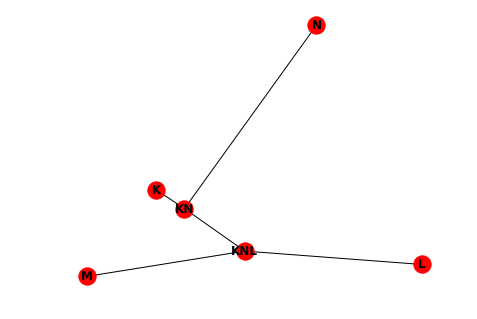

In [338]:
nx.draw(NJ('alignment_matrix_1.txt'), with_labels=True, with_weights=True, font_weight='bold')

/home/hamit/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


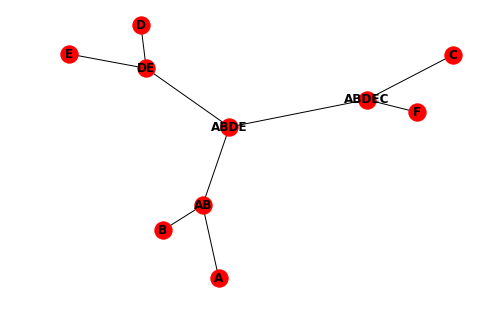

In [318]:
nx.draw(NJ('alignment_matrix_2.txt'), with_labels=True, with_weights=True, font_weight='bold')